<a href="https://colab.research.google.com/github/kelly2110/PRA3024-Analysis-of-Big-Data-in-Physics/blob/main/PRA3024_2223_COSMOLOGY_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='deepskyblue'>Cosmology MCMC notebook </font>

## <font color='deepskyblue'>Preliminaries</font>

In [1]:
# Install required packages (if not available on server)
!pip install getdist

# Load required packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
# import pylab
import getdist, IPython
from numpy import random
# from IPython.display import Image
from getdist import plots, MCSamples, loadMCSamples

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



<font color='tomato'>
(NB: The equations you'll directly need to build your code are those $\boxed{\text{with a box around}}$)
</font>

## <font color='deepskyblue'>The $\Lambda$CDM Model</font>

The Lambda-Cold-Dark-Matter ($\Lambda$CDM) Model is our concordance cosmological model. It postulates a Universe that behaves according to **General Relativity**, filled with **baryons** (protons, neutrons - the stuff we and stars are made of!), **Cold Dark Matter (CDM)** and a **Cosmological Constant** $\Lambda$.

The expansion of the Universe is best described in terms of the **scale factor** $a$ (the "radius" of the Universe, conventionally set to 1 today) and the **Hubble rate** $H$

$$
H \equiv \frac{\dot a}{a}
$$

The Einstein Equations in a **homogeneous, isotropic** Universe have an especially simple form and a special name, **Friedmann Equation**:

$$
H^2 = \frac{8\pi G}{3}\rho + \frac{k}{a^2}
$$

where $\rho$ is the total energy density of the Universe (at a certain time or size), and $k$ is a universal constant related to the [spatial curvature and shape of the Universe](https://en.wikipedia.org/wiki/Shape_of_the_universe#:~:text=The%20spatial%20curvature%20is%20related,indistinguishable%20spaces%20with%20different%20topologies.). In the $\Lambda$CDM model (and at late enough times), this additionally simplifies to

$$
\boxed{
H^2 = H_0^2\left(\Omega_\Lambda + \Omega_m a^{-3} + \Omega_k a^{-2}\right)
}
\qquad
\qquad
\boxed{
\Omega_m + \Omega_\Lambda + \Omega_k = 1
}
\tag{1}
$$

$H_0$ is the value of the Hubble rate *today*, and the parameters $\Omega_m$, $\Omega_\Lambda$ and $\Omega_k$ are dimensionless quantities indicating how much of the present expansion of the Universe is due to (non-relativistic) matter, cosmological constant $\Lambda$, and spatial curvature $k$. Note that the three $\Omega$'s are *not independent* (their sum is 1) and that we grouped together the contribution of baryons and CDM,

$$
\Omega_m = \Omega_{\rm CDM} + \Omega_{\rm b}
$$

and that we have evidence that independent evidence that $\Omega_b \approx 5$\%. Note that only $\Omega_m \geq 0$ makes physical sense, while in principle both $\Omega_\Lambda$ and $\Omega_k$ can be negative.

The present Hubble rate is conventionally parametrised in terms of the dimensionless $h$:

$$
\boxed{H_0 \equiv h\,\frac{100 \,\text{km}}{\text{s Mpc}}}
\tag{2}
$$

where Mpc = Megaparsec and [parsec](https://en.wikipedia.org/wiki/Parsec) equals to about $3.26$ light years or $3.086 \cdot 10^{16}$ m. 

In essence, these equations give us the relation between *what exists in the Universe* and *how the Universe expanded*. Measure one, I can tell you the other. This is precisely what we aim to do!

Time to define the function $H(z)$. Don't forget to include the useful parameters as arguments of the function, and to define `parsec`.

In [2]:
import math
from math import *
import numpy as np
Pc = 3.086E13 #km
Mpc = 3.086E19 #km

def H_0(h):
  return h*100 # km/(s*Mpc)


# Hubble rate: look at equations (1) and (2) for the definition!
def H(z, h, OmegaL, OmegaM):
  OmegaK = 1 - (OmegaL + OmegaM)
  H = math.sqrt((H_0(h)**2)*(OmegaL + OmegaM*((1/(1+z))**(-3)) + OmegaK*(((1/(1+z))**(-2)))))
  return H

# Integrate H from x = 0 \to x = z
def D(z, h, omegaL, omegaM):
    return H_0(h)*(integrate.quad(lambda x: (1/H(x, h, omegaL, omegaM)), 0, z)[0])

print(H(1, 0.7, 0.7, 0.3))
print(D(1, 0.7, 0.7, 0.3))

123.24771803161306
0.7714270664278111


## <font color='deepskyblue'>Supernovae Ia</font>

In order to track the expansion of the Universe, we will look at Supernovae type Ia observations. SNIa are formed when a *white dwarf* accretes matter from a companion until it reaches a critical mass of about $1.44 M_\odot$ (solar masses), after which it explodes **at always the same luminosity** $L_{\rm SN}$. Therefore, the observed [magnitude](https://en.wikipedia.org/wiki/Magnitude_(astronomy)) is only a function of their [**luminosity distance**](https://en.wikipedia.org/wiki/Distance_measures_(cosmology)) from Earth, defined as the ratio of the intrinsic luminosity $L_{\rm SNIa}$ and the measured *surface brightness* $\Phi$ (energy per unit time per unit area)

$$ d_L\equiv \frac{L_{\rm SN}}{4\pi \Phi} $$

While photons (light rays) travel from the distant SNIa to Earth, the Universe expands and the photons get redshifted, and this redshift is directly related to the size of the Universe when the photon was emitted compared to today:

$$ \frac{\lambda_{\rm obs}}{\lambda_{\rm em}} \equiv 1 + z_{\rm em} = \frac{1}{a_{\rm em}}$$

We can express the luminosity distance in terms of the Hubble rate:

$$
\boxed{
d_L(z) = \frac{c}{H_0}(1+z) \times 
\begin{cases}
    \cfrac{1}{\sqrt{\Omega_k}} \,\sinh\left(\sqrt{\Omega_k}\,D(z)\right) & \Omega_k > 0
    \\[.5em]
    D(z) & \Omega_k = 0
    \\[.5em]
    \cfrac{1}{\sqrt{-\Omega_k}} \,\sin\left(\sqrt{-\Omega_k}\,D(z)\right) & \Omega_k < 0
\end{cases}
\qquad\qquad
D(z) \equiv H_0\int_0^z \frac{{\rm d}Z}{H(Z)}
}
\tag{3}
$$

where $c$ is the speed of light: $c \simeq 2.998 \cdot 10^{5}$ km/s.

Clearly, there exists a relation between $d_L(z)$ and $H(z)$, so the luminosity distance is a useful measure of the Universe expansion history. 
In practice, however, the actual observable for [Supernovae Type Ia](https://en.wikipedia.org/wiki/Type_Ia_supernova) (or SNIa) is the [distance modulus](https://en.wikipedia.org/wiki/Distance_modulus) $\mu$, defined as the difference between the *apparent magnitude* $m$ and the *absolute magnitude* $M$:

$$
\boxed{
\mu(z) \equiv m(z) - M \equiv 5 \log_{10} \frac{d_L(z)}{10\,\text{pc}}
}
\tag{4}
$$

We can create the function `dL(z, h, Omega_m, Omega_Lambda)`. You can also pass the function `Hubble` as an argument: `dL(z, Hubble, Omega_m, Omega_Lambda)`. Additionally, you can create $D(z)$ for your convenience.

Note that you need to integrate the function $H(z)$, so write your own quick-and-easy numerical integrator, for example implementing the [trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule) or your favourite alternative, or [look up the pre-written methods](https://docs.scipy.org/doc/scipy/tutorial/integrate.html). Make sure it returns $d_L$ in parsecs and that it uses $H_0$ measured in units of 100 km/s/Mpc (which we called $h$).

In [3]:
c = 2.998E5 #km/s # <--- Choose your favourite units, but make sure you're consistent!
Pc = 3.086E13 #km


def dL(z, h , Omega_Lambda, Omega_m): # luminosity distance
    Omega_K = 1 - (Omega_m + Omega_Lambda)
    
    if Omega_K > 0:
      L = (c/H_0(h))*((1+z)/sqrt(Omega_K))*sinh(sqrt(Omega_K)*D(z, h, Omega_Lambda, Omega_m))

    elif Omega_K == 0:
      L = (c/H_0(h))*(1+z)*D(z, h, Omega_Lambda, Omega_m)

    else:
      L = (c/H_0(h))*((1+z)/sqrt(-Omega_K))*sin(sqrt(-Omega_K)*D(z, h, Omega_Lambda, Omega_m))

    return L #in Mpc

print(dL(1, 0.7, 0.7, 0.3))

def mu(z, h, Omega_Lambda, Omega_m): # distance modulus
     return 5*log10(dL(z, h , Omega_Lambda, Omega_m)/((10/10**6))) #Dividing a number in Mpc by 10 pc.

print(mu(1, 0.7, 0.7, 0.3))

6607.823843287365
44.100292283465386


## <font color='deepskyblue'>The Union2.1 Compilation</font>

Our source of data is from [Union2.1](http://supernova.lbl.gov/Union/). It is a collection of $580$ SNIa, each observation is comprised of redshift $z$ 
Our goal today is to use SNIa measurements to constrain the parameters ($h, \Omega_\Lambda, \Omega_m$).

In essence, we can calculate for each redshift the theoretical value of $\mu$ using this equation with the expression for $d_L(z)$ and our model of choice $H(z)$ -- note that we will need to perform a numerical integral! -- and compare this value with observations. A different model would amount to changing the theoretical value of $H(z)$.

Let us start by importing and plotting the data:

In [4]:
dataloc = "http://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt"

# Read in data as numpy array.
# Format is [name, redshift, magnitude, magnitude error, and another number?]
data = np.genfromtxt(dataloc)

# Print the first line as an example. (Note that genfromtxt turns the names into 'Not A Number')
print(data[0])

[           nan 2.84880000e-02 3.53465834e+01 2.23905933e-01
 1.28418942e-01]


In [5]:
# Extract the redshifts (zs), distance modulus (dist_mod) and magnitude estimated errors (err_dist_mod)
zs = data.T[1] # redshift
distance_modulus = data.T[2] # distance modulus
error_distance_modulus = data.T[3] # errors on distance modulus = sigmas

In [6]:
# Let's look at the data, just for fun. 
# We can look both at the raw data (distance modulus) or calculate the luminosity distance
# Note that Numpy allows us to manipulate whole arrays at once with something like:
#     array_2 = some_function_of(array_1)

# luminosity distance in pc
luminosity_distance_pc = 10. * 10.**(distance_modulus / 5.)

# and in Mpc
luminosity_distance_Mpc = luminosity_distance_pc / 10.**6

# and the error on that distance:
error_luminosity_distance_Mpc = 5. * (10.**((distance_modulus + error_distance_modulus)/5.-6.) - 10.**((distance_modulus - error_distance_modulus)/5.-6.))

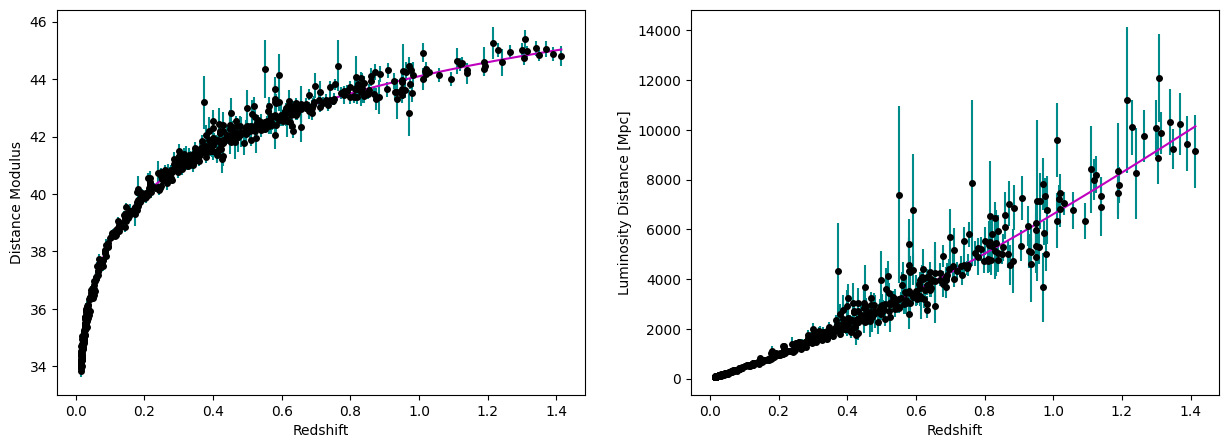

In [7]:
%matplotlib inline
plt.subplots(1, 2, figsize=(15, 5))

# Plot distance modulus versus redshift (original data)
plt.subplot(1, 2, 1)
plt.xlabel("Redshift")
plt.ylabel("Distance Modulus")
plt.errorbar(zs, distance_modulus, yerr=error_distance_modulus, fmt='o', color='black', ecolor='darkcyan', markersize=4)
plt.plot(sorted(zs), list(mu(z, 0.7, 0.7, 0.3) for z in sorted(zs)), 'm')

# Plot luminosity distance versus redshift
plt.subplot(1, 2, 2)
plt.xlabel("Redshift")
plt.ylabel("Luminosity Distance [Mpc]")
plt.errorbar(zs, luminosity_distance_Mpc, yerr=error_luminosity_distance_Mpc, fmt='o', color='black', ecolor='darkcyan', markersize=4)
plt.plot(sorted(zs), list(dL(z, 0.7, 0.7, 0.3) for z in sorted(zs)), 'm')
plt.show()

## <font color='deepskyblue'>Bayes' Theorem: Likelihood, Prior, Posterior (and Evidence...)</font>

The **conditional probability of A given that B is true** is denoted with $P(A|B)$ (read: *probability of A given B*). 
Did A happen? Then B has probability $P(B|A)$ of happening.

[**Bayes' Theorem**](https://en.wikipedia.org/wiki/Bayes%27_theorem) is simply a reflection of the symmetry of the concept of joint probability:

$$
P(A|B)P(B) = P(B|A)P(A)
$$

In physics, our goal is often to determine how likely the values of some parameters $\theta$ are, given how well they reproduce the data $D$. 
We write Bayes' theorem in the following equivalent form:

$$
P(\theta | D) = \frac{P(D|\theta)P(\theta)}{P(D)}
$$

The various terms conventionally take the names:

$$
\begin{aligned}
P(\theta | D) & && \text{Posterior}
\\
P(D | \theta)& && \text{Likelihood}
\\
P(\theta) & && \text{Prior}
\\
P(D) & && \text{Evidence}
\end{aligned}
$$

### <font color='deepskyblue'>Prior</font>

The *prior* quantifies our degree of prior belief in the model parameters. It can contain the results of previous experiments, or theoretical considerations (for instance, that certain parameters cannot be negative, etc.). 

We can have *strong priors* about something - the Sun still existing at night, see the comic below - or not.
When we do *not* have compelling prior knowledge about a parameter, we generally use a *non-informative* prior probability distribution, most often related to the [uniform distribution](https://en.wikipedia.org/wiki/Continuous_uniform_distribution)

$$
\begin{aligned}
    \text{Uniform} & && \theta \in \text{Uniform}[\theta_{\rm min}, \theta_{\rm max}]
    \\
    \text{Log Uniform} & && \log\theta \in \text{Uniform}[\log\theta_{\rm min}, \log\theta_{\rm max}]
\end{aligned}
$$

You may sometimes hear that "the prior doesn't matter". While this is not strictly true, it is however true that in many instances the *likelihood* depends more dramatically on the parameters and will have a dominating contribution to the posterior. You are more than welcome to try different priors for the model parameters and see if and how your results change.

### <font color='deepskyblue'>Likelihood</font>

The measure of how well our model reproduces the data is the **likelihood** $\mathcal L$. For normal (=Gaussian), uncorrelated data $\mu_i$ with errors $\sigma_i$ ($i = \{1,580\}$), the likelihood is related to the famous [**chi-squared**](https://en.wikipedia.org/wiki/Chi-square_distribution) via

$$
P(D | \theta) \equiv \mathcal L = \exp\left(-\frac{\chi^2}{2}\right)
\qquad
\qquad
\boxed{
\chi^2 \equiv \sum_{i=1}^{580} \frac{\left(\mu_i^{(\rm theor)} - \mu_i^{(\rm obs)}\right)^2}{\sigma_i^2}
}
\tag{5}
$$

A *high likelihood* corresponds to a *low chi squared*.

In principle, we could attack the problem brute-force: create a grid of values for $h$, $\Omega_m$, $\Omega_\Lambda$, calculate the likelihood for each combination, and create a profile for the likelihood. 

In practical cases, however, this is not only sub-optimal but sometimes **impossible**. Think of complicated models with 20+ free parameters (this is not that unusual in physics, by the way). Even a very coarse grained grid of 100 values for each parameter would result in more than $10^{40}$ (!!!) different parameter combination to be tested. You can probably understand why this is undesirable.

### <font color='deepskyblue'>Evidence</font>

This is the tricky bit. The evidence, which is "*the probability of observing certain data*", is not something that is easy to evaluate or interpret. This looks like a serious limitation to finding the:


### <font color='deepskyblue'>Posterior</font>

What does the data tell us about the model parameters? The answer is the *posterior probability distribution*, often (but not necessarily) expressed as (average $\pm$ standard deviation)

$$
\theta_i = \bar\theta_i \pm \sigma_i
$$

In other words, the posterior tells us how likely it is for the model parameters to have certain values, *given that we observe the data* $D$.

*This is the final goal of our analysis!*

<br>

![title](http://1.bp.blogspot.com/-tTx4HDejSww/ULcTeK9_V_I/AAAAAAAAA8g/PCYOH-eXGbk/s1600/frequentists_vs_bayesians.png)
![title](https://i.redd.it/5r0hwixt0m931.jpg)

## <font color='deepskyblue'>Markov-Chain Monte Carlo</font>

Markov-Chain Monte Carlo techniques are a class of methods to sample a probability distribution $P(x)$ - in our case $P(\theta | D)$ - provided that we can calculate a density $\mathcal F(x)$ **that is proportional to it** - in our case $P(\theta)P(D|\theta)$ = likelihood $\times$ prior. Among these, a very popular one is the [**Metropolis-Hastings**](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm, which is what we will use.

Schematically, the algorithm works as follows:
* Start with an $n$-tuple of parameters $\theta_{\rm old} = \{\theta_1, \theta_2, \dots\}_{\rm old}$ (in our case $\theta = \{h,\Omega_m,\Omega_\Lambda\}$) and calculate the $\mathcal F_{\rm old}$
* Propose a new set of parameters $\theta_{\rm prop}$, calculate the new corresponding $\mathcal F_{\rm prop}$. How you propose the new parameters is not essential as long as the probability of going from one set of parameters to the next is the same as the inverse: $P(\theta_a \to \theta_b) = P(\theta_b \to \theta_a)$. For this, we normally take Gaussian displacements with some (relatively small) standard deviation.
* Compare the new and old likelihoods-priors:
    * If $\mathcal F_{\rm prop} > \mathcal F_{\rm old}$, accept the step: $\theta_{\rm new} = \theta_{\rm prop}$
    * Otherwise, accept with probability $P_{\rm accept} = \mathcal F_{\rm prop}/\mathcal F_{\rm old}$
* If accepted, $\theta_{\rm new} = \theta_{\rm prop}$ and record the step; otherwise, $\theta_{\rm new} = \theta_{\rm old}$ (no re-recording)
* Update $\theta_{\rm old} = \theta_{\rm new}$
* Repeat

The MC chain keeps going until the desired number of steps or, ideally, when a suitable convergence test, like for example the [Gelman-Rubin test](https://bookdown.org/rdpeng/advstatcomp/monitoring-convergence.html), is satisfied. 
Today we will just set a limit to the total number of steps, but please feel free to implement and test your favourite convergence test!

Looking at equation (5), you can convince yourself that
$$
\frac{\mathcal L_a}{\mathcal L_b} = \exp\left(\frac{\chi_b^2 - \chi_a^2}{2}\right)
$$

(This is useful because $\chi^2$ can be large, so we want to avoid the likelihoods evaluating to `0.` -- computers don't like dividing by zero, unfortunately)

 
* <font color="deepskyblue"> Start with an $n$-tuple of parameters $\theta_{\rm old} = \{\theta_1, \theta_2, \dots\}_{\rm old}$ (in our case $\theta = \{h,\Omega_m,\Omega_\Lambda\}$) and the corresponding chi squared $\chi_{\rm old}^2$ (to be clear, for us this implies calculating a series of 580 integrals and comparing each with the observed values) </font>
* <font color="deepskyblue"> Propose new parameters $\theta_{\rm prop}$ and calculate the corresponding chi squared $\chi_{\rm prop}^2$</font>
* <font color="deepskyblue"> Draw a random number $r \in [0,1]$</font>
* <font color="deepskyblue"> Accept the step if 
$$
r < \exp\left(\frac{\chi_{\rm old}^2 - \chi_{\rm prop}^2}{2}\right) \frac{P(\theta)_{\rm prop}}{P(\theta)_{\rm old}}
$$</font>
    * <font color="deepskyblue"> If accepted, update $\theta_{\rm old} = \theta_{\rm prop}$, and record; otherwise, $\theta_{\rm new} = \theta_{\rm old}$ (no re-recording)</font>
    * <font color="deepskyblue">If you want, you can keep a record of the best fit (lowest $\chi^2$), but this is not the specific purpose of MCMC! We are exploring the parameter space and sampling a _posterior distribution_, not just finding the best fit</font>
* <font color="deepskyblue"> Repeat</font>

In [8]:
filename = "MC_Chain_SNIa.dat" # Or choose your favourite filename, obviously
file = open(filename,"w")



N_steps = 1500

# Start from some very bad values, to show that the MCMC works anyway!
Omega_M = 0.1 
Omega_L = 0.1
h = 0.1

# PUT YOUR MCMC CODE HERE!

def ChiSqrd(h, Omega_L, Omega_M):
  sum = 0
  for i in range(580):
    sum += ((mu(data.T[1][i], h , Omega_L, Omega_M) - data.T[2][i])**2)/(data.T[3][i]**2)
  return sum

# Make lists to store variables
array_h, array_OmegaM, array_OmegaL = [],[],[]

chi_L = []
iter = 0
while True:
  
  # defining new parameters 
  new_Omega_L = random.normal(Omega_L, 0.01)
  new_Omega_M = abs(random.normal(Omega_M, 0.01))
  new_h = random.normal(h, 0.01)

  #find the chi squared of old and new parameters
  old_Chi = ChiSqrd(h, Omega_L, Omega_M)
  new_Chi = ChiSqrd(new_h, new_Omega_L, new_Omega_M)

  #finding the old and new likelihoods
  oldProp = exp(-old_Chi/2)
  newProp = exp(-new_Chi/2)

  try:
    r = exp((old_Chi - new_Chi)/2)
  except OverflowError:
    r = float('inf')

  # Taking a random number between 0 and 1 , checking if it's smaller than r
  if random.uniform(0,1) < r:
    iter += 1
    h = new_h
    Omega_L = new_Omega_L
    Omega_M = new_Omega_M

    array_OmegaL.append(Omega_L)
    array_OmegaM.append(Omega_M)
    array_h.append(h)

    chi_L.append(old_Chi)

    print(round(Omega_M,3), round(Omega_L,3), round(h,3), old_Chi) #prints values of parameters
    if iter > N_steps:
      break
  
file.close();

0.098 0.104 0.12 334849.61148863524
0.098 0.122 0.121 275388.9963320745
0.112 0.146 0.123 271702.5880121841
0.115 0.167 0.125 266480.1828057876
0.119 0.147 0.138 263527.7206792818
0.125 0.152 0.146 232296.3540244343
0.134 0.135 0.147 215743.32084017183
0.129 0.136 0.158 213457.3232861791
0.123 0.155 0.164 194138.45048324444
0.135 0.147 0.175 184161.85183283346
0.128 0.145 0.178 168154.76754915464
0.142 0.134 0.184 164401.16389913688
0.126 0.14 0.186 155559.58319831372
0.125 0.129 0.198 152574.18177251515
0.14 0.131 0.211 138710.80679438368
0.134 0.117 0.215 123982.28513210065
0.147 0.115 0.228 120047.53911705635
0.15 0.103 0.232 107969.49555573583
0.146 0.098 0.235 104517.08115690638
0.151 0.086 0.247 102035.34105992291
0.145 0.089 0.276 92648.88647308963
0.144 0.091 0.286 73065.31154440569
0.156 0.082 0.304 67823.4605310131
0.176 0.09 0.315 58245.50018005519
0.166 0.083 0.317 53043.22106005586
0.17 0.085 0.32 52157.30349952835
0.181 0.08 0.322 51042.20090669504
0.174 0.102 0.326 49769

After completion of the programme, your MC chain will (*hopefully*) look something like this:

`#Omega_m  Omega_L  h`

`0.297     0.703    0.698`

`0.285     0.715    0.701`

`0.288     0.712    0.699`

`...`

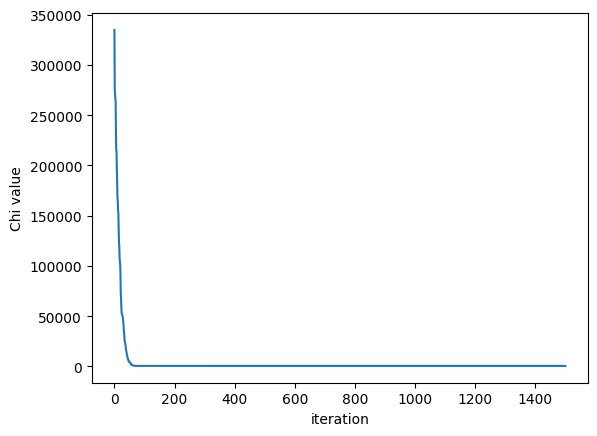

In [9]:
plt.plot(chi_L)
plt.ylabel("Chi value")
plt.xlabel("iteration")
plt.show()

## <font color='deepskyblue'>Plotting: GetDist</font>

We will do the plots with [`GetDist`](https://getdist.readthedocs.io/en/latest/plot_gallery.html).

The plot gallery contains a lot of useful examples, you should be able to read them fairly easily and see which applies to your situation. Look for both (triangle) plots and for parameter estimation.

Note that many `GetDist` functions require arguments of type `MCSamples`; make sure you convert your lists accordingly.

<p>
<font color='deepskyblue'>
Look at your results. Do you obtain $\Omega_\Lambda \neq 0$ to a high degree of significance? 

If yes, then my dear friend, you have **DISCOVERED THE ACCELERATED EXPANSION OF THE UNIVERSE AND WON THE NOBEL PRIZE IN PHYSICS 2011!**
</font>
</p>

Removed no burn in
0.69  <  h  <  0.71  at  95 % CL
0.16  <  OmegaM  <  0.34  at  95 % CL
0.57  <  OmegaL  <  0.78  at  95 % CL
-0.1  <  Omegak  <  0.25  at  95 % CL





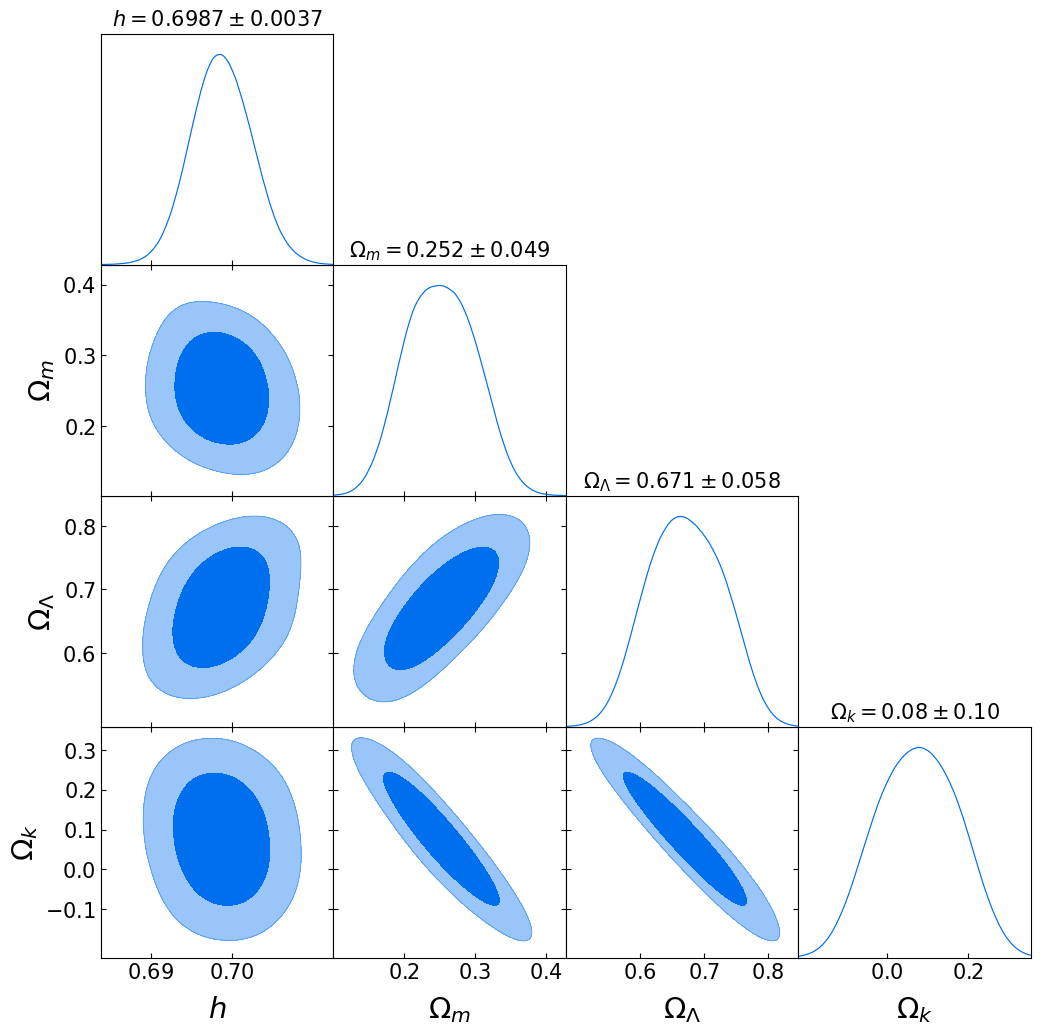

In [11]:
# These are just randomly generated values. YOU WILL HAVE TO USE THE RESULTS OF YOUR MCMC CHAIN!
h, OmegaM, OmegaL = np.array(array_h), np.array(array_OmegaM), np.array(array_OmegaL)

Omegak = 1. - OmegaL - OmegaM

# Here let's just define variable names, labels, and so on
my_labels = [r'h', r'\Omega_m', r'\Omega_\Lambda', r'\Omega_k']
my_names = ['h', 'OmegaM', 'OmegaL', 'Omegak']
my_dim = 4 # The number of variables we're plotting

my_samples = np.array([h, OmegaM, OmegaL, Omegak]) # This creates a higher-dimensional array with all our data,
my_samples = np.transpose(np.reshape(my_samples,(my_dim,int(my_samples.size/my_dim)))) # and this reshapes it in a convenient form...

#Burning some of the data
burn_percent_cutoff = int(len(my_samples) * 0.20)
burned_samples = my_samples[burn_percent_cutoff:]

samples1 = MCSamples(samples = burned_samples, labels = my_labels, names = my_names) # ... to create an "MCSamples" data type, which GetDist can use

conf_level = 0.9545 # The usual 1-sigma confidence level. You can change to 2- or 3-sigma if you want

# Let's print a table with the 1D posteriors (confidence levels)
for nam in my_names:
    print(round(samples1.confidence(nam,(1.-conf_level)/2.,upper=False),2), \
          " < ", nam , " < ", round(samples1.confidence(nam,(1.-conf_level)/2.,upper=True),2),\
          " at " , int(100*conf_level),"\b% CL")
print("\n\n")

#Triangle corner plot
j = plots.getSubplotPlotter(subplot_size=3)
j.settings.axes_labelsize = 22
j.settings.axes_fontsize = 16
j.triangle_plot(samples1, filled = True, title_limit=1)

## <font color='deepskyblue'>Further Improvements</font>

There are many ways in which you can improve your code and/or your data visualisation. Some ideas, in random order:

* Modify your priors and compare your results. For instance:
  * Change to log-flat priors for $h$ and/or $\Omega_m$, namely displace them in log-space instead of linear space:
  $$
  \log(h_{\rm new}) = \log(h_{\rm old}) + \delta
  $$
  where $\delta$ a random variable of mean 0
  * Use priors from other cosmological probes, for example the [Planck 2018 results](https://arxiv.org/abs/1807.06209):
  $$
  \Omega_m = 0.315 \pm 0.007\,,~\dots
  $$
* Implement a Gelman-Rubin (or alternative) convergence test
* Change colours and other properties of your triangle plot
* Re-plot the data with your theoretical fits: you can try both your best fit, and some $1\sigma$ "error bars"
* Split your data in redshift bins and repeat the analysis for each bin individually.
<br> _(What do you notice? Which redshift bins give us the most accurate detection of the cosmological parameters?)_